# CART Model for AQI and Concentration Prediction of Pollutants

The Classification and Regression Tree (CART) Algorithm is used to build decision trees based on minimizing the Mean Squared Error. For the initial baseline model, the features that are considered are date-time variables. The date-time variables were split into features such as 'month', 'day', 'hour of day', 'day of year', 'week of year', 'weekday', 'quarter', 'is month start', 'is month end'. 'month', 'weekday', 'quarter', and 'is month start' variables were one-hot encoded to avoid any significance based on its value since it is nominal data. The data was split into train set and last 120 samples (5 days) as validation set. After playing aroud with the hyperparameters, a Random Forest Regressor with 1000 estimators (to prevent overfitting) and max depth of 50 was used to train the model which gave the best results in terms of RMSE values. It is observed that the model follows the trends in the data while predicting.

### Import Libraries

In [41]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [8]:
# Reading the data
df = pd.read_csv("/content/all_outlier_removed.csv")
df.head()

,Timestamp,Ozone_Concentration,PM2.5_Concentration,Ozone_Unit,PM2.5_Unit,Ozone_AQI,PM2.5_AQI,Ozone_AQI_Category,PM2.5_AQI_Category
0,2023-01-05T19:00,32.0,5.4,PPB,UG/M3,30.0,23.0,1.0,1.0
1,2023-01-05T20:00,31.0,4.8,PPB,UG/M3,29.0,20.0,1.0,1.0
2,2023-01-05T21:00,35.0,4.1,PPB,UG/M3,32.0,17.0,1.0,1.0
3,2023-01-05T22:00,30.0,3.9,PPB,UG/M3,28.0,16.0,1.0,1.0
4,2023-01-05T23:00,27.0,4.1,PPB,UG/M3,25.0,17.0,1.0,1.0


In [10]:
df = df.copy()

#### Checking for null values in the data

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7259 entries, 0 to 7258
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            7259 non-null   object 
 1   Ozone_Concentration  7259 non-null   float64
 2   PM2.5_Concentration  7259 non-null   float64
 3   Ozone_Unit           7240 non-null   object 
 4   PM2.5_Unit           7211 non-null   object 
 5   Ozone_AQI            7259 non-null   float64
 6   PM2.5_AQI            7259 non-null   float64
 7   Ozone_AQI_Category   7259 non-null   float64
 8   PM2.5_AQI_Category   7259 non-null   float64
dtypes: float64(6), object(3)
memory usage: 510.5+ KB


#### Adding future timestamps for the week (11/06 to 11/11) to the original dataframe so that the timestamp preprocessing steps are consistent throughtout.

In [12]:
future_dates_df = pd.DataFrame(pd.date_range('2023-11-06T00:00', '2023-11-10T23:59', freq='1H'), columns = ["Timestamp"])
df = pd.concat((df, future_dates_df))
df.tail()

,Timestamp,Ozone_Concentration,PM2.5_Concentration,Ozone_Unit,PM2.5_Unit,Ozone_AQI,PM2.5_AQI,Ozone_AQI_Category,PM2.5_AQI_Category
115,2023-11-10 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,2023-11-10 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,2023-11-10 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,2023-11-10 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,2023-11-10 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# convert timestamp to datetime datatype
df['Date'] = pd.to_datetime(df['Timestamp'])

# set the format for the datetime
df['Date'] = df['Date'].dt.strftime('%Y-%m-%dT%H:%M')

# extract the year from the timestamp
df['year'] = pd.DatetimeIndex(df['Date']).year

# extract the month of the year from timestamp
df['month'] = pd.DatetimeIndex(df['Date']).month

# extract the day of the month from timestamp
df['day'] = pd.DatetimeIndex(df['Date']).day

# extract the hour of the day from timestamp
df['hourofday'] = pd.DatetimeIndex(df['Date']).hour

# extract the day of the year from timestamp
df['dayofyear'] = pd.DatetimeIndex(df['Date']).dayofyear

# extract the week of the year from timestamp
df['weekofyear'] = pd.DatetimeIndex(df['Date']).weekofyear

# extract the day of the week from timestamp
df['weekday'] = pd.DatetimeIndex(df['Date']).weekday

# extract the quarter of the year in which the month belongs to
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter

# extract boolean which corresponds to start and end of the month
df['is_month_start'] = pd.DatetimeIndex(df['Date']).is_month_start
df['is_month_end'] = pd.DatetimeIndex(df['Date']).is_month_end

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7379 entries, 0 to 119
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            7379 non-null   object 
 1   Ozone_Concentration  7259 non-null   float64
 2   PM2.5_Concentration  7259 non-null   float64
 3   Ozone_Unit           7240 non-null   object 
 4   PM2.5_Unit           7211 non-null   object 
 5   Ozone_AQI            7259 non-null   float64
 6   PM2.5_AQI            7259 non-null   float64
 7   Ozone_AQI_Category   7259 non-null   float64
 8   PM2.5_AQI_Category   7259 non-null   float64
 9   Date                 7379 non-null   object 
 10  year                 7379 non-null   int64  
 11  month                7379 non-null   int64  
 12  day                  7379 non-null   int64  
 13  hourofday            7379 non-null   int64  
 14  dayofyear            7379 non-null   int64  
 15  weekofyear           7379 non-null   in

<ipython-input-13-d074623d198b>:23: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = pd.DatetimeIndex(df['Date']).weekofyear


#### Intuitively selected a set of columns from the original columns that are considered as features while fitting the Decision Trees

In [50]:
considered_cols = ['month', 'day', 'hourofday', 'dayofyear', 'weekofyear', 'weekday',
              'quarter', 'is_month_start', 'is_month_end']
pred_cols = ['Ozone_Concentration', 'Ozone_AQI', 'PM2.5_Concentration', 'PM2.5_AQI' ]

In [51]:
df_curr = df[considered_cols + pred_cols]
df_curr.head()

,month,day,hourofday,dayofyear,weekofyear,weekday,quarter,is_month_start,is_month_end,Ozone_Concentration,Ozone_AQI,PM2.5_Concentration,PM2.5_AQI
0,1,5,19,5,1,3,1,False,False,32.0,30.0,5.4,23.0
1,1,5,20,5,1,3,1,False,False,31.0,29.0,4.8,20.0
2,1,5,21,5,1,3,1,False,False,35.0,32.0,4.1,17.0
3,1,5,22,5,1,3,1,False,False,30.0,28.0,3.9,16.0
4,1,5,23,5,1,3,1,False,False,27.0,25.0,4.1,17.0


### One hot enconding the year, month, weekday, quarter, is_month_start, and is_month_end columns since these are nominal data

In [52]:
df_curr = pd.get_dummies(df_curr, columns=['month'], drop_first=True, prefix='month')
df_curr = pd.get_dummies(df_curr, columns=['weekday'], drop_first=True, prefix='wday')
df_curr = pd.get_dummies(df_curr, columns=['quarter'], drop_first=True, prefix='qrtr')
df_curr = pd.get_dummies(df_curr, columns=['is_month_start'], drop_first=True, prefix='m_start')
df_curr = pd.get_dummies(df_curr, columns=['is_month_end'], drop_first=True, prefix='m_end')

#### Separating features of the concurrent timestamps to fit an ML model and features of the future timestamps for predictions.

In [53]:
df_future = df_curr.iloc[-len(future_dates_df) : , :]
df_temp = df_curr.iloc[:-len(future_dates_df) , : ]
df_future.head()

,day,hourofday,dayofyear,weekofyear,Ozone_Concentration,Ozone_AQI,PM2.5_Concentration,PM2.5_AQI,month_2,month_3,...,wday_2,wday_3,wday_4,wday_5,wday_6,qrtr_2,qrtr_3,qrtr_4,m_start_True,m_end_True
0,6,0,310,45,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,1,0,0
1,6,1,310,45,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,1,0,0
2,6,2,310,45,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,1,0,0
3,6,3,310,45,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,1,0,0
4,6,4,310,45,NaN,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,0,1,0,0


In [54]:
# it is expected that AQI_PM2.5 will have all missing values
df_future.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   day                  120 non-null    int64  
 1   hourofday            120 non-null    int64  
 2   dayofyear            120 non-null    int64  
 3   weekofyear           120 non-null    int64  
 4   Ozone_Concentration  0 non-null      float64
 5   Ozone_AQI            0 non-null      float64
 6   PM2.5_Concentration  0 non-null      float64
 7   PM2.5_AQI            0 non-null      float64
 8   month_2              120 non-null    uint8  
 9   month_3              120 non-null    uint8  
 10  month_4              120 non-null    uint8  
 11  month_5              120 non-null    uint8  
 12  month_6              120 non-null    uint8  
 13  month_7              120 non-null    uint8  
 14  month_8              120 non-null    uint8  
 15  month_9              120 non-null    uin

In [55]:
df_temp.head()

,day,hourofday,dayofyear,weekofyear,Ozone_Concentration,Ozone_AQI,PM2.5_Concentration,PM2.5_AQI,month_2,month_3,...,wday_2,wday_3,wday_4,wday_5,wday_6,qrtr_2,qrtr_3,qrtr_4,m_start_True,m_end_True
0,5,19,5,1,32.0,30.0,5.4,23.0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,5,20,5,1,31.0,29.0,4.8,20.0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,5,21,5,1,35.0,32.0,4.1,17.0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,5,22,5,1,30.0,28.0,3.9,16.0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,5,23,5,1,27.0,25.0,4.1,17.0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [56]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7259 entries, 0 to 7258
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   day                  7259 non-null   int64  
 1   hourofday            7259 non-null   int64  
 2   dayofyear            7259 non-null   int64  
 3   weekofyear           7259 non-null   int64  
 4   Ozone_Concentration  7259 non-null   float64
 5   Ozone_AQI            7259 non-null   float64
 6   PM2.5_Concentration  7259 non-null   float64
 7   PM2.5_AQI            7259 non-null   float64
 8   month_2              7259 non-null   uint8  
 9   month_3              7259 non-null   uint8  
 10  month_4              7259 non-null   uint8  
 11  month_5              7259 non-null   uint8  
 12  month_6              7259 non-null   uint8  
 13  month_7              7259 non-null   uint8  
 14  month_8              7259 non-null   uint8  
 15  month_9              7259 non-null   u

In [57]:
df_temp = df_temp.dropna()

#### Splitting train and validation samples for performance comparison
> Validation samples are considered for the last 5 days of the available dataset. i.e. (24 hours x 5 days = 120 samples)

In [58]:
df_train = df_temp.iloc[:-120, :]
df_test = df_temp.iloc[-120:, :]
df_train.head()

,day,hourofday,dayofyear,weekofyear,Ozone_Concentration,Ozone_AQI,PM2.5_Concentration,PM2.5_AQI,month_2,month_3,...,wday_2,wday_3,wday_4,wday_5,wday_6,qrtr_2,qrtr_3,qrtr_4,m_start_True,m_end_True
0,5,19,5,1,32.0,30.0,5.4,23.0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,5,20,5,1,31.0,29.0,4.8,20.0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,5,21,5,1,35.0,32.0,4.1,17.0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,5,22,5,1,30.0,28.0,3.9,16.0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,5,23,5,1,27.0,25.0,4.1,17.0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [59]:
df_test.head()

,day,hourofday,dayofyear,weekofyear,Ozone_Concentration,Ozone_AQI,PM2.5_Concentration,PM2.5_AQI,month_2,month_3,...,wday_2,wday_3,wday_4,wday_5,wday_6,qrtr_2,qrtr_3,qrtr_4,m_start_True,m_end_True
7139,30,21,303,44,20.0,19.0,1.8,8.0,0,0,...,0,0,0,0,0,0,0,1,0,0
7140,30,22,303,44,21.0,19.0,1.9,8.0,0,0,...,0,0,0,0,0,0,0,1,0,0
7141,30,23,303,44,22.0,20.0,2.0,8.0,0,0,...,0,0,0,0,0,0,0,1,0,0
7142,31,0,304,44,22.0,20.0,2.6,11.0,0,0,...,0,0,0,0,0,0,0,1,0,1
7143,31,1,304,44,22.0,20.0,3.5,15.0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [60]:
X_train = np.array(df_train.drop(pred_cols, axis = 1))

In [61]:
X_test = np.array(df_test.drop(pred_cols, axis = 1))

In [62]:
X_future = np.array(df_future.drop(pred_cols, axis = 1))

# Building Prediction Models

## Random Forest Regressor

### Import Libraries

In [63]:
from sklearn import model_selection
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt


RMSE on train data for Ozone_Concentration is : 2.276014505593468
R2 score on train data for Ozone_Concentration is: 0.9695720253275149

RMSE on test data for Ozone_Concentration is: 9.763135760633535
R2 score on test data for Ozone_Concentration is: 0.21017003018125258

RMSE on train data for Ozone_AQI is : 2.103505803916981
R2 score on train data for Ozone_AQI is: 0.9690848481231611

RMSE on test data for Ozone_AQI is: 8.93980453735618
R2 score on test data for Ozone_AQI is: 0.22298226507511476

RMSE on train data for PM2.5_Concentration is : 0.5695637868060631
R2 score on train data for PM2.5_Concentration is: 0.9897281638248097

RMSE on test data for PM2.5_Concentration is: 3.200732906704189
R2 score on test data for PM2.5_Concentration is: -0.007489831897282251

RMSE on train data for PM2.5_AQI is : 2.058330223810551
R2 score on train data for PM2.5_AQI is: 0.989666996253352

RMSE on test data for PM2.5_AQI is: 12.924416716697788
R2 score on test data for PM2.5_AQI is: -0.09342456

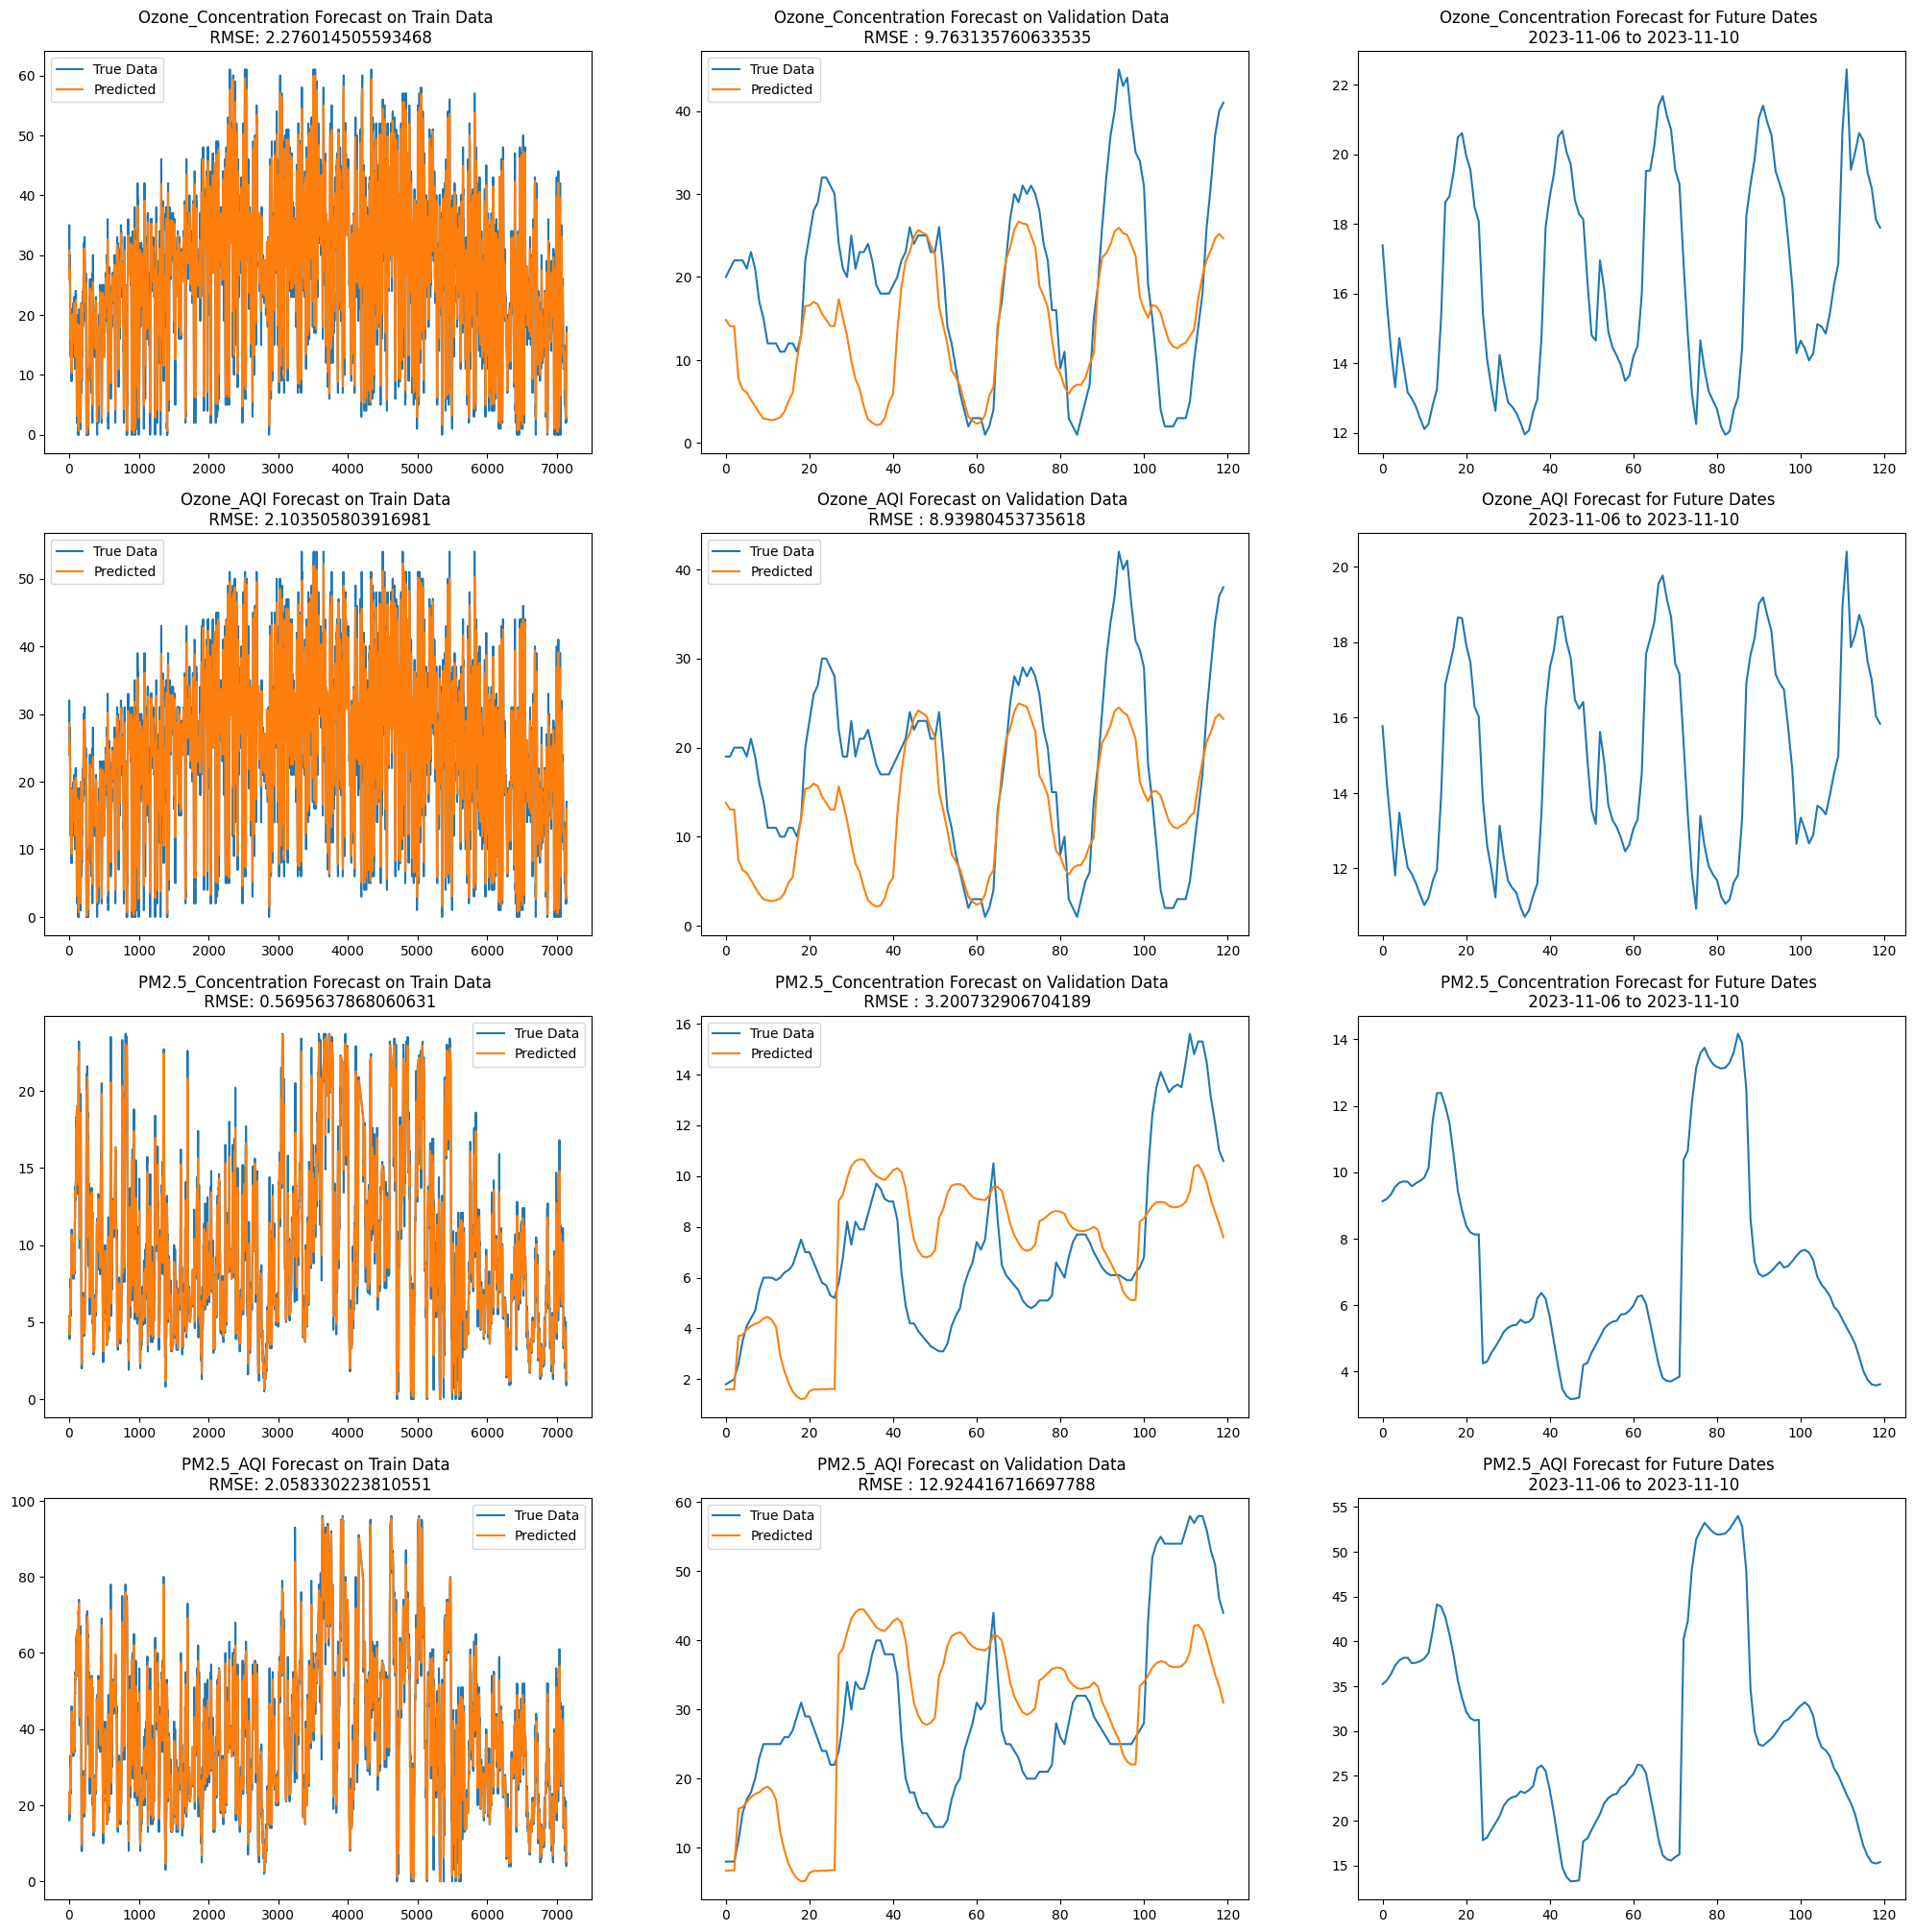

In [64]:
plt.figure(figsize = (25, 25))
id = 1
final_result = np.zeros((120,4))

for i, var in enumerate(pred_cols):
  # defining the model
  y_train = np.array(df_train[var])
  y_test = np.array(df_test[var])

  dtree = RandomForestRegressor(n_estimators = 1000, max_depth = 50, min_samples_split = 2,
                                min_samples_leaf = 2, random_state = 43)

  # fit the model to the train data
  dtree.fit(X_train, y_train)

  # make predictions on the train data

  pred_train_tree= dtree.predict(X_train)
  print(f'RMSE on train data for {var} is :', np.sqrt(mean_squared_error(y_train,pred_train_tree)))
  print(f'R2 score on train data for {var} is:', r2_score(y_train, pred_train_tree))
  print()

  plt.subplot(4,3, id)
  idx = range(len(y_train))
  plt.title(f'{var} Forecast on Train Data \n RMSE: {np.sqrt(mean_squared_error(y_train,pred_train_tree))}')
  plt.plot(idx, y_train, label = 'True Data')
  plt.plot(idx, pred_train_tree, label = 'Predicted')
  plt.legend()

  id+=1

  pred_test_tree = dtree.predict(X_test)

  print(f'RMSE on test data for {var} is:', np.sqrt(mean_squared_error(y_test,pred_test_tree)))
  print(f'R2 score on test data for {var} is:', r2_score(y_test, pred_test_tree))
  print()

  plt.subplot(4,3, id)
  idx = range(len(y_test))
  plt.title(f'{var} Forecast on Validation Data \n RMSE : {np.sqrt(mean_squared_error(y_test,pred_test_tree))}')
  plt.plot(idx, y_test, label = 'True Data')
  plt.plot(idx, pred_test_tree, label = 'Predicted')
  plt.legend()

  id+=1

  plt.subplot(4,3, id)
  pred_future_tree = dtree.predict(X_future)

  plt.title(f'{var} Forecast for Future Dates \n 2023-11-06 to 2023-11-10')

  idx = range(len(pred_future_tree))

  final_result[:, i] = pred_future_tree

  plt.plot(idx, pred_future_tree)

  id+=1

In [65]:
np.savetxt(f'final_result.csv', final_result, delimiter=",", header= "O, AQI_O, PM2.5, AQI_PM2.5", comments='')